# Transfer Learning / Feature extraction

## 1. Load dataset

In [1]:
from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [0]:
import requests
from pathlib import Path

def maybe_download(url):
  """ Downloads file from url, unless file exists """
  filename = url.split('/')[-1]
  local_path = Path(filename)
  
  if not local_path.exists():
    r = requests.get(url)
    with local_path.open('wb') as fp:
      for chunk in r.iter_content(chunk_size=1024 ** 2): 
          if chunk:
              fp.write(chunk)
              
  return local_path

In [0]:
import tarfile
import gzip

def extract_tgz(local_path):
  """ extracts file, overwrites if necessary. """
  with tarfile.open(str(local_path)) as tar:
    tar.extractall()

In [0]:
local_path = maybe_download("https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")
extract_tgz(local_path)

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

167190528/170498071 [============================>.] - ETA: 0s

170500096/170498071 [==============================] - 42s 0us/step


In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## 2. Visualize dataset

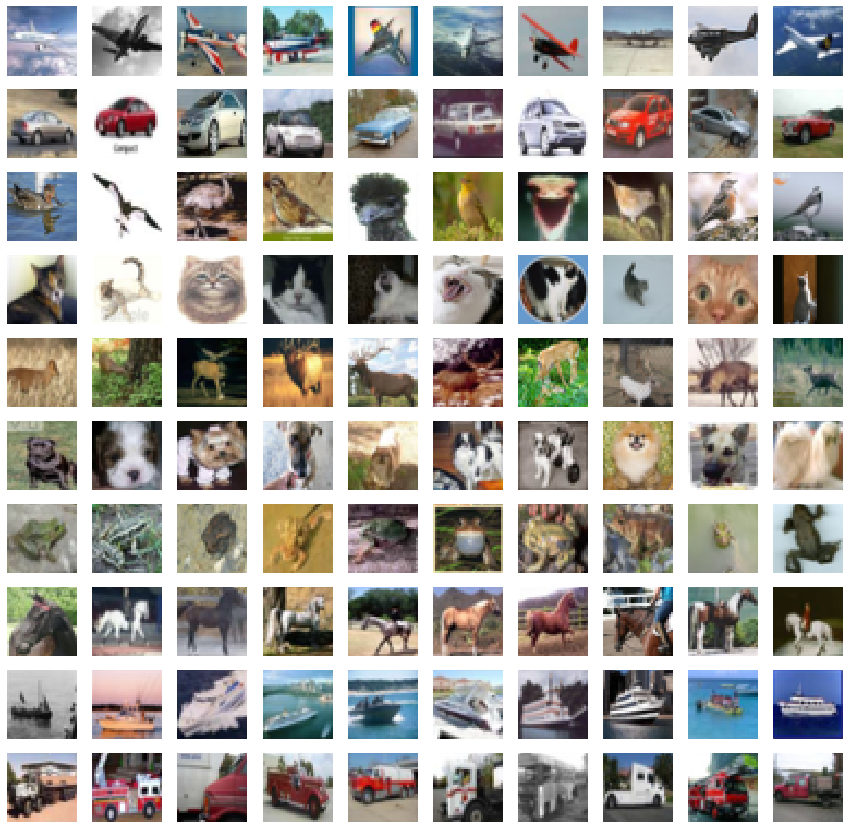

In [11]:
positions = np.reshape(np.arange(len(y_train)), (-1, 1))

plt.figure(figsize=(15, 15))
for i in range(10):
  for j, index in enumerate(np.random.choice(positions[y_train == i], 10, replace=False)):
    plt.subplot(10, 10, i * 10 + (j + 1))
    plt.imshow(x_train[index, :, :, :])
    plt.grid(False)
    plt.tick_params(axis='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

## 3. Train shallow classifier

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
import cv2

In [0]:
winSize = (20,20)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64

# winSize = (8,8)
# blockSize = (16,16)
# blockStride = (8,8)
# cellSize = (8,8)
# nbins = 9
# derivAperture = 1
# winSigma = 4.
# histogramNormType = 0
# L2HysThreshold = 2.0000000000000001e-01
# gammaCorrection = 0
# nlevels = 64

useSignedGradients = True
 
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                        histogramNormType, L2HysThreshold, gammaCorrection, nlevels, useSignedGradients)

In [0]:
descriptor = hog.compute(x_train[0, :, :, :])

In [8]:
descriptor.flatten().shape

(324,)

In [9]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
x_train_hog = np.zeros((x_train.shape[0], 324))

In [0]:
for i in range(50000):
  x_train_hog[i, :] = hog.compute(x_train[i, :, :, :]).flatten()

In [0]:
x_test_hog = np.zeros((x_test.shape[0], 324))

In [0]:
for i in range(10000):
  x_test_hog[i, :] = hog.compute(x_test[i, :, :, :]).flatten()

In [0]:
from sklearn.svm import SVC

In [0]:
clf = SVC()

In [16]:
clf.fit(x_train_hog, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [17]:
clf.score(x_test_hog, y_test)

0.4869

## 4. Extract visual features from pretrained network



1.   standard image preprocessing
2.   pretrained model specific preprocessing



In [7]:
model = VGG16(include_top=False, input_shape=(48, 48, 3), weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [9]:
model_inc = InceptionV3(include_top=False, input_shape=(160, 160, 3), weights='imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [10]:
model_inc.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 79, 79, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 79, 79, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

We don't want any non-convolutional layers (fully connected) because we loose spatial information.

In [0]:
for layer in model.layers:
  layer.trainable = False

Check if all layers have been frozen (trainable parameters count should be 0).

In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_283 (Conv2D)             (None, 79, 79, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 79, 79, 32)   96          conv2d_283[0][0]                 
__________________________________________________________________________________________________
activation_283 (Activation)     (None, 79, 79, 32)   0           batch_normalization_283[0][0]    
__________________________________________________________________________________________________
conv2d_284

__________________________________________________________________________________________________
mixed9 (Concatenate)            (None, 3, 3, 2048)   0           activation_359[0][0]             
                                                                 mixed9_0[0][0]                   
                                                                 concatenate_7[0][0]              
                                                                 activation_367[0][0]             
__________________________________________________________________________________________________
conv2d_372 (Conv2D)             (None, 3, 3, 448)    917504      mixed9[0][0]                     
__________________________________________________________________________________________________
batch_normalization_372 (BatchN (None, 3, 3, 448)    1344        conv2d_372[0][0]                 
__________________________________________________________________________________________________
activation

CIFAR10's images are too small for the model, so we need to resize them to the proper size > 139. I've chosen $32 \cdot 5 = 160$. 

In [0]:
image_gen = ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE=50

In [9]:
input_train = image_gen.flow(x_train, y_train, batch_size=BATCH_SIZE, target_size=(160, 160))
input_test = image_gen.flow(x_test, y_test, batch_size=BATCH_SIZE, target_size=(160, 160))

TypeError: ignored

In [0]:
model.compile(optimizer='sgd', loss='categorical_crossentropy')

In [0]:
model.predict_generator(input_train)

In [19]:
(140 - 32) / 2

54.0